In [7]:
# Import modules
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import copy
from torch.distributions import Normal
from config import num_of_simulations
from config import simulation_length

# Import network objects
from PolicyNetwork import PolicyNetwork
from ValueNetwork import ValueNetwork

In [8]:
# Train using gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_of_sensors = 50
input_size = 4*num_of_sensors+2
simulation_length = 100
accel_policy = PolicyNetwork(input_size)
turn_policy = PolicyNetwork(input_size)
value_function = ValueNetwork(input_size)

# Network locations
acceleration_path = 'models/acceleration_network.pth'
turn_path = 'models/turn_network.pth'
value_path = 'models/value_network.pth'

# Load networks
accel_policy.load_state_dict(torch.load(acceleration_path))
turn_policy.load_state_dict(torch.load(turn_path))
value_function.load_state_dict(torch.load(value_path))

accel_policy.to(device)
turn_policy.to(device)
value_function.to(device)


ValueNetwork(
  (layers): Sequential(
    (0): Linear(in_features=202, out_features=202, bias=True)
    (1): Tanh()
    (2): LayerNorm((202,), eps=1e-05, elementwise_affine=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=202, out_features=202, bias=True)
    (5): Tanh()
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=202, out_features=1, bias=True)
  )
)

In [ ]:
def shuffle_data(data):
    
    # Reshape data into rows partitioned by simulation
    data.reshape(num_of_simulations,simulation_length)
    # Shuffle each row
    np.apply_along_axis(np.random.shuffle, axis=1, arr=data)
    # Transpose of array
    data = data.T
    # Shuffle each row
    np.apply_along_axis(np.random.shuffle, axis=1, arr=data)
    # Flatten array
    res = res.flatten()
    return res

In [ ]:
# Load and read trajectory csv file
trajectories_file = 'data/trajectories.csv'
trajectories_df = pd.read_csv(trajectories_file)
trajectories = trajectories_df.to_numpy()

# Store trajectory values into state, action, reward vectors
states = trajectories[:, 1:-3]
actions = trajectories[:, -3:-1]
rewards = trajectories[:, -1:]

gamma = 0.99 # Discount factor

# Calculate reward-to-go
'''
FIX USING NUMPY CUMILATIVE SUM
reward_to_go = np.array([[reward[0]] for reward in rewards])
for i in range(len(reward_to_go)-2,-1,-1): 
    if i%simulation_length != 0 and i != 0: reward_to_go[i][0] += reward_to_go[i+1][0]*gamma
'''

past_rewards = np.copy(rewards)
for i in range(rewards.shape[0]//simulation_length):
    rewards[i*simulation_length:(i+1)*simulation_length,-1:] = rewards[i*simulation_length:(i+1)*simulation_length,-1::-1].cumsum(axis=1)[::-1]

# Convert to tensor
states_tensor = torch.tensor(states).float()
actions_tensor = torch.tensor(actions).float()
reward_to_go_tensor = torch.tensor(rewards).float()
#Store in dataset
dataset = TensorDataset(states_tensor, reward_to_go_tensor, actions_tensor)
dataloader = DataLoader(dataset, batch_size=256, shuffle=False)

Train value function

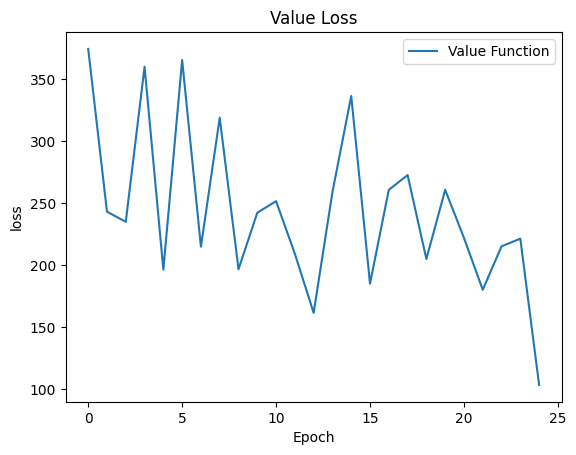

In [13]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(value_function.parameters(), lr=0.0001)

losses = []
epochs = 25
for epoch in range(epochs):
    for inputs_batch, outputs_batch, _ in dataloader:
        # Move batches to GPU
        inputs_batch, outputs_batch = inputs_batch.to(device), outputs_batch.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        predictions = value_function(inputs_batch)

        # Compute the loss
        loss = loss_function(predictions, outputs_batch)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()

    losses.append(loss.item())
plt.title('Value Loss')
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.plot(losses,label='Value Function')
plt.legend()
plt.show()

Train Policy Networks

In [14]:
# Load networks
accel_policy.load_state_dict(torch.load(acceleration_path))
turn_policy.load_state_dict(torch.load(turn_path))
value_function.load_state_dict(torch.load(value_path))

accel_policy.to(device)
turn_policy.to(device)
value_function.to(device)

policy_optimizer = optim.Adam(list(accel_policy.parameters())+list(turn_policy.parameters()),lr=0.0001)
value_optimizer = optim.Adam(value_function.parameters(),lr=0.0001)


epsilon = 0.2 # Clipping factor

policy_losses = []
value_losses = []

epochs = 10

for epoch in range(epochs):
    for inputs_batch, outputs_batch, actions_batch in dataloader:
        # Move batches to GPU
        inputs_batch, outputs_batch, actions_batch = inputs_batch.to(device), outputs_batch.to(device), actions_batch.to(device)

        # Clone current policy and value networks
        accel_policy_old = copy.deepcopy(accel_policy)
        turn_policy_old = copy.deepcopy(turn_policy)
        value_function_old = copy.deepcopy(value_function)

        values = value_function(inputs_batch)

        # Freeze clone networks
        for param in accel_policy_old.parameters(): param.requires_grad = False
        for param in turn_policy_old.parameters(): param.requires_grad = False
        for param in value_function_old.parameters(): param.requires_grad = False

        # Calculate advantages
        advantages = outputs_batch.cpu() - value_function_old(inputs_batch).cpu().numpy()
        advantages = advantages.to(device)

        # Get old policy distribution from policy networks
        accel_mean_old, accel_stdev_old = accel_policy_old(inputs_batch)[:,0],accel_policy_old(inputs_batch)[:,1]
        turn_mean_old, turn_stdev_old = turn_policy_old(inputs_batch)[:,0],turn_policy_old(inputs_batch)[:,1]

        # Get new policy distribution from policy networks
        accel_mean, accel_stdev = accel_policy(inputs_batch)[:,0],accel_policy(inputs_batch)[:,1]
        turn_mean, turn_stdev = turn_policy(inputs_batch)[:,0],turn_policy(inputs_batch)[:,1]
        
        # Get acceleration and turn from actions taken
        accelerations = torch.tensor(actions_batch[:,0]).to(device)
        turns = torch.tensor(actions_batch[:,1]).to(device)

        # Get probability distribution based on network outputs
        accel_dist_old = Normal(accel_mean_old,accel_stdev_old)
        accel_dist = Normal(accel_mean,accel_stdev)
        turn_dist_old = Normal(turn_mean_old,turn_stdev_old)
        turn_dist = Normal(turn_mean,turn_stdev)

        # Calculate log probabities
        pi = accel_dist.log_prob(accelerations) + turn_dist.log_prob(turns)    
        pi_old = accel_dist_old.log_prob(accelerations) + turn_dist_old.log_prob(turns)    

        # Calculate probability ratios
        ratios = torch.exp(pi - pi_old)

        # Compute PPO loss
        surr1 = ratios * advantages
        surr2 = torch.clamp(ratios, 1 - epsilon, 1 + epsilon) * advantages # Clipping
        ppo_loss = -torch.min(surr1,surr2).mean()
        
        # Update policy net
        policy_optimizer.zero_grad()
        ppo_loss.backward()
        policy_optimizer.step()

        # Update value network
        value_loss = nn.MSELoss()(values,outputs_batch)
        value_optimizer.zero_grad()
        value_loss.backward()
        value_optimizer.step()

    policy_losses.append(ppo_loss.item())
    value_losses.append(value_loss.item())

# Plotting side-by-side graphs
plt.figure(figsize=(12, 5))

# Policy Loss plot
plt.subplot(1, 2, 1)
plt.plot(policy_losses, color='r', label='Policy Loss')
plt.title('Policy Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Value Loss plot
plt.subplot(1, 2, 2)
plt.plot(value_losses, color='b', label='Value Loss')
plt.title('Value Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Display the graphs
plt.tight_layout()
plt.show()

C:\Users\mattd\AppData\Local\Temp\ipykernel_27476\1540907635.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  accelerations = torch.tensor(actions_batch[:,0]).to(device)
C:\Users\mattd\AppData\Local\Temp\ipykernel_27476\1540907635.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  turns = torch.tensor(actions_batch[:,1]).to(device)


ValueError: Expected parameter loc (Tensor of shape (256,)) of distribution Normal(loc: torch.Size([256]), scale: torch.Size([256])) to satisfy the constraint Real(), but found invalid values:
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       device='cuda:0')

Save trained models

In [6]:
# Save models
torch.save(accel_policy.state_dict(), acceleration_path)
torch.save(turn_policy.state_dict(), turn_path)
torch.save(value_function.state_dict(), value_path)

Clear trajectory data

In [7]:
# Load the CSV to get the columns
trajectories = pd.read_csv(trajectories_file)

# Create an empty DataFrame with the same columns

trajectories.drop(trajectories.index, inplace=True)

# Overwrite the original CSV file, keeping only the column headers
trajectories.to_csv(trajectories_file, index=False)